# 1. Import Libraries and Data

In [1]:
!pip install einops

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import torch
from torch import nn, einsum
import numpy as np
from einops import rearrange, repeat
import torch.nn as nn
import torch.nn.functional as F
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")

sns.set_context("paper", font_scale=1.4)

# Preprocessing Data

In [5]:
# preprocess the dataset to resize and generate masks
# X_train, Y_train, X_valid, Y_valid = prepare_tensor_dataset("../input/cityscapes-image-pairs/cityscapes_data/train/", "../input/cityscapes-image-pairs/cityscapes_data/val/")

# load the processed images: https://www.kaggle.com/datasets/sapreatharva/data00
X_train = np.load('xtrain.npy')
Y_train = np.load('ytrain.npy')
X_valid = np.load('xval.npy')
Y_valid = np.load('yval.npy')
X_test = np.load('xtest.npy')
Y_test = np.load('ytest.npy')

# convert to array
X_train = torch.from_numpy(X_train).permute(0, 3, 1, 2).float()
Y_train = torch.from_numpy(np.int32(Y_train)).permute(0, 3, 1, 2)
X_valid = torch.from_numpy(X_valid).permute(0, 3, 1, 2).float()
Y_valid = torch.from_numpy(np.int32(Y_valid)).permute(0, 3, 1, 2)
X_test = torch.from_numpy(np.int32(Y_test)).permute(0, 3, 1, 2)
Y_test = torch.from_numpy(np.int32(Y_test)).permute(0, 3, 1, 2)


In [17]:
#class mapping
id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 4,
    18: 4,
    19: 5,
    20: 6,
    21: 6,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7
}

num_classes = len(id_map.keys())

In [18]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

torch.Size([2975, 3, 256, 256])
torch.Size([2975, 1, 256, 256])
torch.Size([500, 3, 256, 256])
torch.Size([500, 1, 256, 256])
torch.Size([300, 3, 256, 256])
torch.Size([300, 1, 256, 256])


#  Architecture Overview

**SWIN TRANSFORMER**

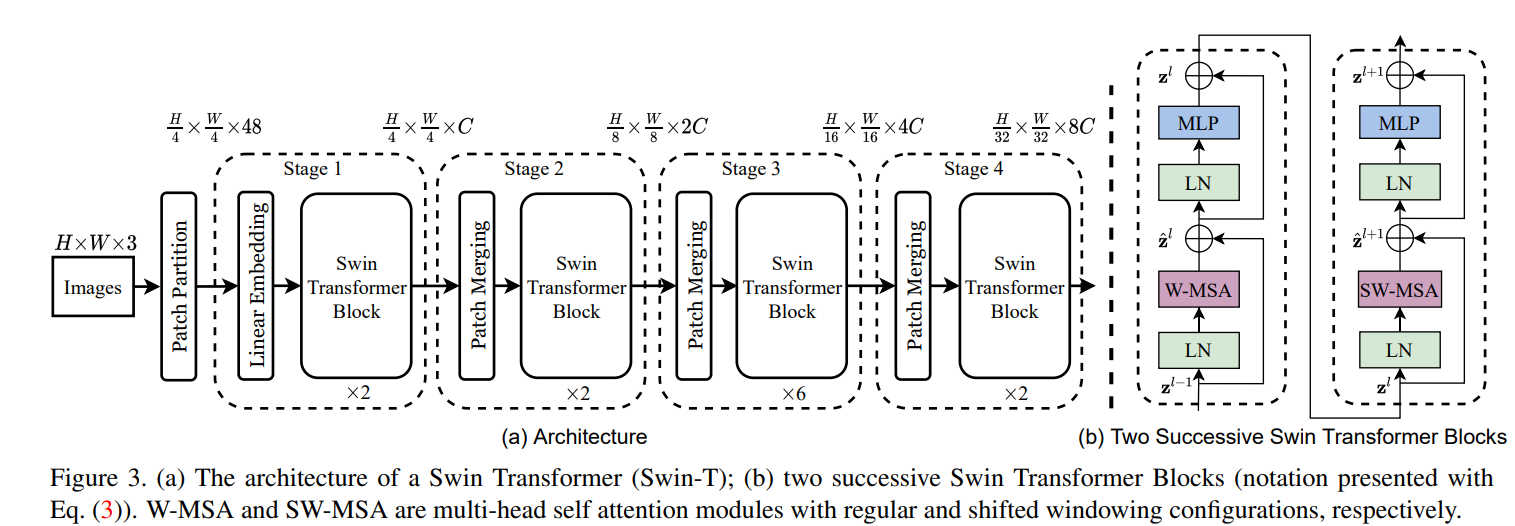



-------------------------------------------------------------------------------------------------------------------------------------------------

**SWIN UNET**

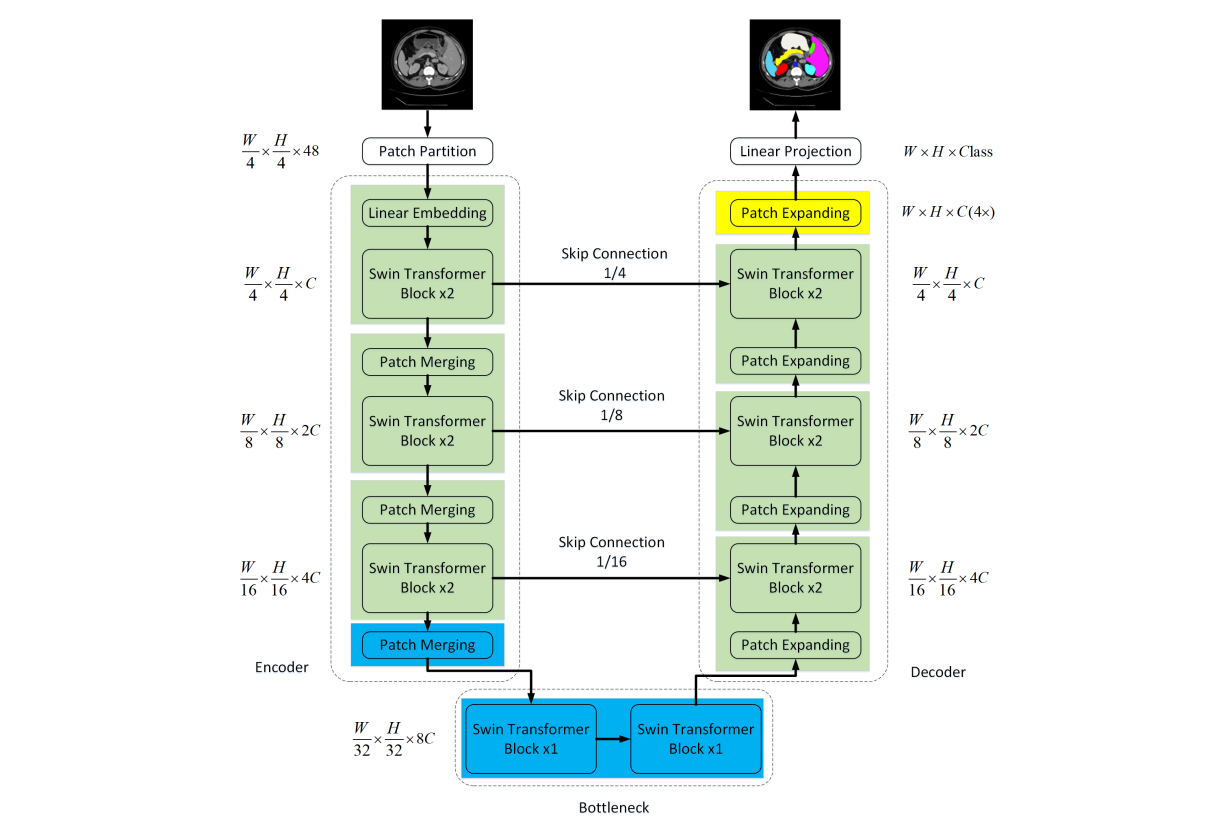

References: (1)
            (2)

# MODEL

In [9]:
# function definitions for SWIN Transformer
class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)


def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask


def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances


class WindowAttention(nn.Module):
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted

        if self.shifted:
            displacement = window_size // 2
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                             upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                            upper_lower=False, left_right=True), requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)

        b, n_h, n_w, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        nw_h = n_h // self.window_size
        nw_w = n_w // self.window_size

        q, k, v = map(
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                                h=h, w_h=self.window_size, w_w=self.window_size), qkv)

        dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        if self.relative_pos_embedding:
            dots += self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        else:
            dots += self.pos_embedding

        if self.shifted:
            dots[:, :, -nw_w:] += self.upper_lower_mask
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask

        attn = dots.softmax(dim=-1)

        out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                        h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
        out = self.to_out(out)

        if self.shifted:
            out = self.cyclic_back_shift(out)
        return out


class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                     heads=heads,
                                                                     head_dim=head_dim,
                                                                     shifted=shifted,
                                                                     window_size=window_size,
                                                                     relative_pos_embedding=relative_pos_embedding)))
        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x


class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()
        self.downscaling_factor = downscaling_factor
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)
    def forward(self, x):
        b, c, h, w = x.shape
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)
        x = self.linear(x)
        #print("PMx.shape: ",x.shape)
        return x

from einops import rearrange

class PatchExpanding(nn.Module):
    # def __init__(self, in_channels, out_channels, dim_scale=2, norm_layer=nn.LayerNorm):
    def __init__(self, in_channels, out_channels, upscaling_factor):    
        super().__init__()
        self.expand = nn.Linear(in_channels, in_channels*2, bias=False) if upscaling_factor == 2 else nn.Identity()
    def forward(self, x):
        B, C, H, W = x.shape
        #print("x.shape: ",x.shape)
        x = x.view(B, C, H*W)
        x = x.permute(0, 2, 1)
        #print("x.shape: ",x.shape)
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=2, p2=2, c=C // 4)
        x = x.view(B, -1, C // 4)
        # x = self.norm(x)
        B, L, C = x.shape
        #print("L:",L)
        x = x.view(B, int(L**(0.5)), int(L**(0.5)),C)
        #print("x.shape: ",x.shape)
        return x

class PatchFinalExpanding(nn.Module):
    # def __init__(self, in_channels, out_channels, dim_scale=2, norm_layer=nn.LayerNorm):
    def __init__(self, in_channels, out_channels, upscaling_factor):    
        super().__init__()
        self.upscaling_factor = upscaling_factor
        self.in_channels = in_channels
        self.out_channels= out_channels
        self.expand = nn.Linear(in_channels, in_channels*16, bias=False)
    
    def forward(self, x):
        B, C, H, W = x.shape
        #print("x.shape: ",x.shape)
        x = x.view(B, C, H*W)
        x = x.permute(0, 2, 1)
        #print("x.shape: ",x.shape)
        x = self.expand(x)
        
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        
        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.upscaling_factor, p2=self.upscaling_factor, c=C // (self.upscaling_factor**2))
        x = x.view(B, -1, self.in_channels)
        # x = self.norm(x)
        B, L, C = x.shape
        #print("L:",L)
        x = x.view(B, int(L**(0.5)), int(L**(0.5)),C)
        #print("x.shape: ",x.shape)
        return x
    
class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging(in_channels=in_channels, out_channels=hidden_dimension,
                                            downscaling_factor=downscaling_factor, )

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        x = self.patch_partition(x)
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)
            # print(x.permute(0, 3, 1, 2).shape)
        return x.permute(0, 3, 1, 2)

class StageModule_Up(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchExpanding(in_channels=in_channels, out_channels=hidden_dimension,
                                            upscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        x = self.patch_partition(x)
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)
        return x.permute(0, 3, 1, 2)

class SwinTransformer(nn.Module):
    def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=1000, head_dim=32, window_size=7,
                 downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
        super().__init__()
        
        # Encoder
        self.stage1 = StageModule(in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
                                  downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage2 = StageModule(in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
                                  downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage3 = StageModule(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
                                  downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        
        # Bottle Neck
        self.stage4 = StageModule(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
                                  downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        
        # Decoder
        self.stage5 = StageModule_Up(in_channels=hidden_dim * 8, hidden_dimension=hidden_dim * 4, layers=layers[3],
                                     downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                                     window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        # self.concat_linear5 = nn.Linear(int(hidden_dim * 2 ** 3), int(hidden_dim * 2 ** 2))
        self.concat_l5 = torch.nn.Conv2d(768, 384, kernel_size=1)
        
        self.stage6 = StageModule_Up(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 2, layers=layers[2],
                                     downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                                     window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.concat_l6 = torch.nn.Conv2d(384, 192, kernel_size=1)
        
        self.stage7 = StageModule_Up(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim, layers=layers[1],
                                     downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                                     window_size=window_size, relative_pos_embedding=relative_pos_embedding) 
        self.concat_l7 = torch.nn.Conv2d(192, 96, kernel_size=1)
            
        self.PFE = PatchFinalExpanding(in_channels=hidden_dim, out_channels=hidden_dim, upscaling_factor=downscaling_factors[0] )
        
        self.output = nn.Conv2d(in_channels=hidden_dim, out_channels=num_classes, kernel_size=1, bias=False)
        

        
        
        self.mlp_head = nn.Sequential(nn.LayerNorm(hidden_dim * 8), nn.Linear(hidden_dim * 8, num_classes))
        
        


    def forward(self, img):
        
        # Encoder
        x1 = self.stage1(img) # size=(N,  96, 32, 32)
        x2 = self.stage2(x1)  # size=(N, 192, 16, 16)
        x3 = self.stage3(x2)  # size=(N, 384,  8,  8)

        # BottleNeck
        x4 = self.stage4(x3)  # size=(N, 768,  4,  4)
        #print("x4: ",x4.shape)
        
        # Decoder 
        x5 = self.stage5(x4) # size=(N, 384,  8,  8)
        #print("x5: ",x5.shape)
        #x5 = x5 + x3
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.concat_l5(x5)
        #print("conx5: ",x5.shape)
        
        x6 = self.stage6(x5) # size=(N, 192, 16, 16)
        #print("x6: ",x6.shape)
        #x6 = x6 + x2
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.concat_l6(x6)
        
        x7 = self.stage7(x6) # size=(N,  96, 32, 32)
        #print("x7: ",x7.shape)
        #x7 = x7 + x1
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.concat_l7(x7)
        #print("conx7: ",x7.shape)
        x8 = self.PFE(x7).permute(0,3,1,2)
        #print("x8: ",x8.shape)
        score = self.output(x8)
        
  

        return score

# Train

## A. Train & Evaluate Function

In [20]:
# preprocess for evaluation
from PIL import Image

def preprocess(path):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256)).resize((128, 128))
    img2 = img.crop((256, 0, 512, 256)).resize((128, 128))
    img1 = np.array(img1) / 255.
    img2 = np.array(img2)
    mask = np.zeros(shape=(img2.shape[0], img2.shape[1]), dtype = np.uint32)
    for row in range(img2.shape[0]):
        for col in range(img2.shape[1]):
            a = img2[row, col, :]
            final_key = None
            final_d = None
            for key, value in id_map.items():
                d = np.sum(np.sqrt(pow(a - value, 2)))
                if final_key == None:
                    final_d = d
                    final_key = key
                elif d < final_d:
                    final_d = d
                    final_key = key
            mask[row, col] = final_key
    mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
    del img2
    return img1, mask

class VizCallback(): 
    def __init__(self, file_path):
        self.file_path = file_path
    
    def on_epoch_end(self,model):
        img, mask = preprocess(self.file_path)
        img = np.array(img)
        img = np.reshape(img, (1, 128, 128, 3))
        pred = model(torch.from_numpy(img).to(device).permute(0, 3, 1, 2).float())
        #print("Pred size:", pred.size())
        y_pred = torch.argmax(pred, axis=1)
        #print("y_pred size:", y_pred.size())
        y_pred=y_pred.cpu().detach().numpy()
        #print("y_pred shape:", y_pred.shape)
        #y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 128))
        fig, axes = plt.subplots(nrows = 1, ncols = 2)
        axes[0].imshow(mask,cmap="gist_rainbow")
        axes[0].set_title("Original Mask")
        axes[1].imshow(y_pred,cmap="gist_rainbow")
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()
        


In [11]:
# train and evaluate functions
import time
import torch.nn.functional as F
def mean_iou(logits, y_test, num_classes):
    with torch.no_grad():
        preds = torch.argmax(logits, dim=1)
        ious = []
        for cls in range(num_classes):
            tp = torch.sum((preds == cls) & (y_test == cls))
            fp = torch.sum((preds == cls) & (y_test != cls))
            fn = torch.sum((preds != cls) & (y_test == cls))
            iou = tp.float() / (tp + fp + fn).float().clamp(min=1e-8)
            ious.append(iou.item())
        miou = sum(ious) / num_classes
    return miou

def train(model, dataloader, loss_func, device, grad_norm_clip):
    '''
    Input: 
    - model: model to be trained
    - dataloader: the dataloader containing the data
    - loss_func: the loss function
    - device: 'cpu' or 'cuda'
    - grad_norm_clip: the maximum gradient norm allowed to prevent exploding gradients
    '''
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 100
    start_time = time.time()
    
    for idx, (label, img) in enumerate(dataloader):

        label = label.to(device)
        text = text.to(device)
        optimizer.zero_grad()
        
        logits = None
        

        logits = model(img)
        # print(logits.shape) --> 1 31 128 128 , 1 1 128 128
        
        # Calculate loss
        criterion = nn.CrossEntropyLoss()
        # Reshape logits and labels
        logits = logits.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
        label = label.view(-1).long()
        loss = criterion(logits, label)
        
        # do the gradient backpropagation
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        
        # Calculate Accuracy
        correct=torch.eq(logits.argmax(1),label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
        
        miou = mean_iou(logits, label, num_classes=31)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| train accuracy {:8.3f} | train loss: {:.5f}  | train mIOU: {:.3f} '.format(epoch, idx, len(dataloader),accuracy,loss, miou,dice))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(model, dataloader, loss_func, device):
    '''
    Input: 
    - model: model to be trained
    - dataloader: the dataloader containing the data
    - loss_func: the loss function
    - device: 'cpu' or 'cuda'
    '''
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            label = label.to(device)
            text = text.to(device)
            
            # compute the logits of the input, get the loss.                    
            # Compute logits of input text
            logits = model(text)
        
            # get the loss
            criterion = nn.CrossEntropyLoss()
            # Reshape logits and labels
            logits = logits.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)
            label = label.view(-1).long()
            # Calculate loss
            loss = criterion(logits, label)
        
            # Caluclate Accuracy
            correct = torch.eq(logits.argmax(1),label).int()
            accuracy = float(correct.sum()) / float(correct.numel())
            miou = mean_iou(logits, label, num_classes=31)
        
    return accuracy, loss, miou

## 4.2 Dataloader

In [22]:
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader  

def make_dataloader(x, y, batch_size, is_train):
    dataset = TensorDataset(torch.from_numpy(y).long(), torch.from_numpy(x).float())
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=2, drop_last=is_train)
    return dataloader
    
train_loader = make_dataloader(X_train.numpy(), Y_train.numpy(), 8, True)
for idx, (lab, im) in enumerate(train_loader):
    if idx > 1:
        break
    #print(im.shape, lab)

In [23]:
Y_train.numpy().shape

(2975, 1, 256, 256)

## 4.3 Training 

In [24]:
# Define Model
# assert torch.cuda.is_available()
device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinTransformer(
    hidden_dim=96,
    layers=(2, 2, 6, 2),
    heads=(3, 6, 12, 24),
    channels=3,
    num_classes=31,
    head_dim=32,
    window_size=4,
    downscaling_factors=(4, 2, 2, 2),
    relative_pos_embedding=True
)
loss_func = torch.nn.CrossEntropyLoss()
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

| epoch   1 |   100/  185 batches | train accuracy    0.759 | train loss: 0.87957  | train mIOU: 0.190
------------------------------------------------------------------------------------------------------------------------
| end of epoch   1 | time: 39.78s | valid accuracy:    0.737 | valid loss: 0.88740 | valid mIOU: 0.177


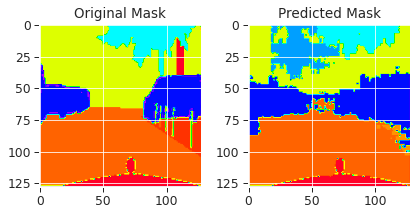

------------------------------------------------------------------------------------------------------------------------
| epoch   2 |   100/  185 batches | train accuracy    0.768 | train loss: 0.89696  | train mIOU: 0.195
------------------------------------------------------------------------------------------------------------------------
| end of epoch   2 | time: 40.95s | valid accuracy:    0.730 | valid loss: 0.90953 | valid mIOU: 0.187


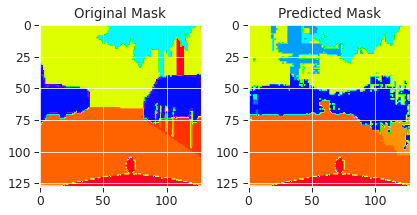

------------------------------------------------------------------------------------------------------------------------
| epoch   3 |   100/  185 batches | train accuracy    0.770 | train loss: 0.83770  | train mIOU: 0.186
------------------------------------------------------------------------------------------------------------------------
| end of epoch   3 | time: 39.93s | valid accuracy:    0.725 | valid loss: 0.91155 | valid mIOU: 0.175


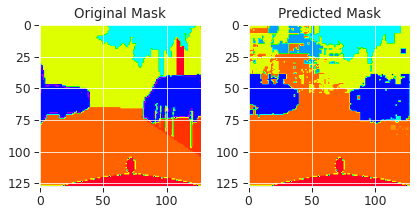

------------------------------------------------------------------------------------------------------------------------
| epoch   4 |   100/  185 batches | train accuracy    0.756 | train loss: 0.88183  | train mIOU: 0.179
------------------------------------------------------------------------------------------------------------------------
| end of epoch   4 | time: 39.90s | valid accuracy:    0.704 | valid loss: 0.97056 | valid mIOU: 0.161


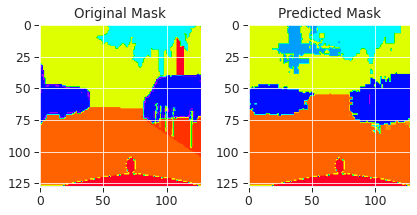

------------------------------------------------------------------------------------------------------------------------
| epoch   5 |   100/  185 batches | train accuracy    0.740 | train loss: 0.96978  | train mIOU: 0.172
------------------------------------------------------------------------------------------------------------------------
| end of epoch   5 | time: 39.77s | valid accuracy:    0.707 | valid loss: 0.98454 | valid mIOU: 0.162


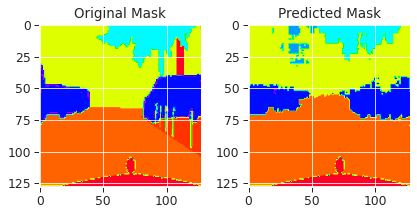

------------------------------------------------------------------------------------------------------------------------
| epoch   6 |   100/  185 batches | train accuracy    0.701 | train loss: 1.14975  | train mIOU: 0.162
------------------------------------------------------------------------------------------------------------------------
| end of epoch   6 | time: 39.71s | valid accuracy:    0.745 | valid loss: 0.87499 | valid mIOU: 0.188


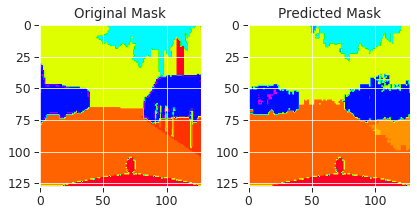

------------------------------------------------------------------------------------------------------------------------
| epoch   7 |   100/  185 batches | train accuracy    0.757 | train loss: 0.91753  | train mIOU: 0.191
------------------------------------------------------------------------------------------------------------------------
| end of epoch   7 | time: 39.78s | valid accuracy:    0.684 | valid loss: 1.04002 | valid mIOU: 0.158


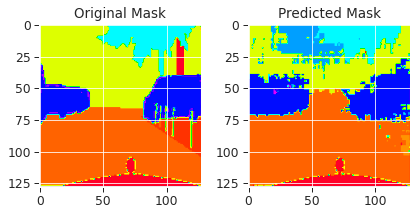

------------------------------------------------------------------------------------------------------------------------
| epoch   8 |   100/  185 batches | train accuracy    0.720 | train loss: 0.97881  | train mIOU: 0.174
------------------------------------------------------------------------------------------------------------------------
| end of epoch   8 | time: 39.85s | valid accuracy:    0.676 | valid loss: 1.11866 | valid mIOU: 0.149


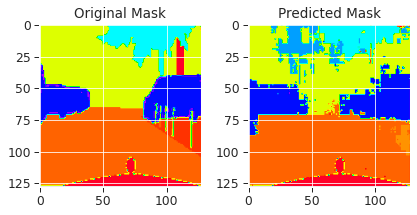

------------------------------------------------------------------------------------------------------------------------
| epoch   9 |   100/  185 batches | train accuracy    0.713 | train loss: 1.06289  | train mIOU: 0.188
------------------------------------------------------------------------------------------------------------------------
| end of epoch   9 | time: 40.09s | valid accuracy:    0.694 | valid loss: 1.00804 | valid mIOU: 0.154


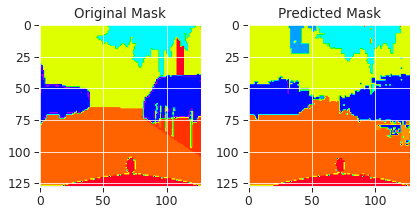

------------------------------------------------------------------------------------------------------------------------
| epoch  10 |   100/  185 batches | train accuracy    0.772 | train loss: 0.67557  | train mIOU: 0.222
------------------------------------------------------------------------------------------------------------------------
| end of epoch  10 | time: 42.54s | valid accuracy:    0.719 | valid loss: 0.78691 | valid mIOU: 0.201


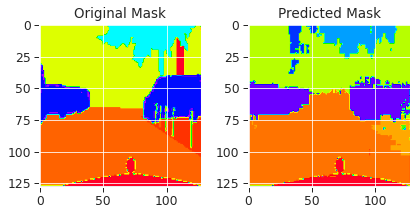

------------------------------------------------------------------------------------------------------------------------
| epoch  11 |   100/  185 batches | train accuracy    0.731 | train loss: 0.81692  | train mIOU: 0.212
------------------------------------------------------------------------------------------------------------------------
| end of epoch  11 | time: 40.12s | valid accuracy:    0.712 | valid loss: 0.84677 | valid mIOU: 0.191


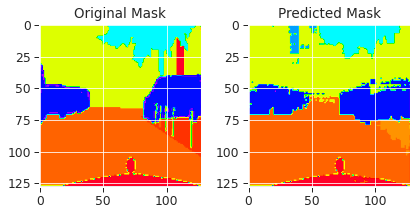

------------------------------------------------------------------------------------------------------------------------
| epoch  12 |   100/  185 batches | train accuracy    0.720 | train loss: 0.92701  | train mIOU: 0.218
------------------------------------------------------------------------------------------------------------------------
| end of epoch  12 | time: 40.45s | valid accuracy:    0.711 | valid loss: 0.79107 | valid mIOU: 0.210


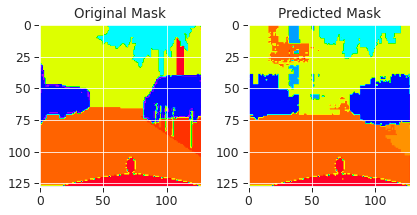

------------------------------------------------------------------------------------------------------------------------
| epoch  13 |   100/  185 batches | train accuracy    0.742 | train loss: 0.82364  | train mIOU: 0.218
------------------------------------------------------------------------------------------------------------------------
| end of epoch  13 | time: 40.93s | valid accuracy:    0.721 | valid loss: 0.80117 | valid mIOU: 0.187


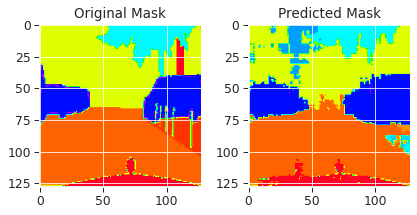

------------------------------------------------------------------------------------------------------------------------
| epoch  14 |   100/  185 batches | train accuracy    0.784 | train loss: 0.69635  | train mIOU: 0.244
------------------------------------------------------------------------------------------------------------------------
| end of epoch  14 | time: 40.73s | valid accuracy:    0.724 | valid loss: 0.75780 | valid mIOU: 0.199


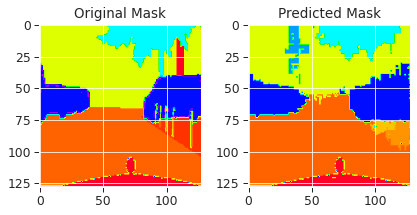

------------------------------------------------------------------------------------------------------------------------
| epoch  15 |   100/  185 batches | train accuracy    0.798 | train loss: 0.57844  | train mIOU: 0.278
------------------------------------------------------------------------------------------------------------------------
| end of epoch  15 | time: 40.85s | valid accuracy:    0.725 | valid loss: 0.73357 | valid mIOU: 0.230


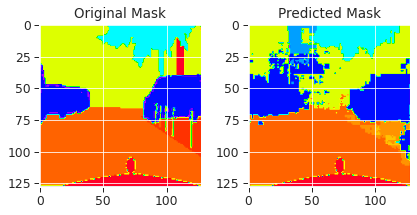

------------------------------------------------------------------------------------------------------------------------
| epoch  16 |   100/  185 batches | train accuracy    0.799 | train loss: 0.59455  | train mIOU: 0.280
------------------------------------------------------------------------------------------------------------------------
| end of epoch  16 | time: 41.15s | valid accuracy:    0.729 | valid loss: 0.78884 | valid mIOU: 0.223


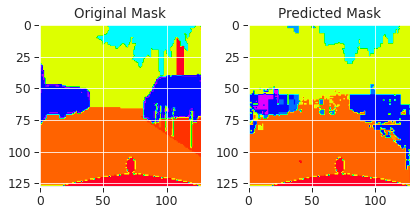

------------------------------------------------------------------------------------------------------------------------
| epoch  17 |   100/  185 batches | train accuracy    0.801 | train loss: 0.53576  | train mIOU: 0.283
------------------------------------------------------------------------------------------------------------------------
| end of epoch  17 | time: 40.92s | valid accuracy:    0.744 | valid loss: 0.74697 | valid mIOU: 0.236


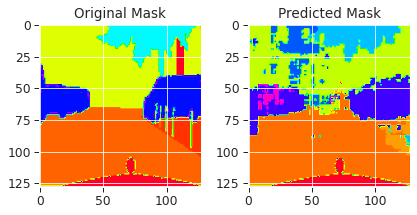

------------------------------------------------------------------------------------------------------------------------
| epoch  18 |   100/  185 batches | train accuracy    0.765 | train loss: 0.68511  | train mIOU: 0.247
------------------------------------------------------------------------------------------------------------------------
| end of epoch  18 | time: 40.95s | valid accuracy:    0.717 | valid loss: 0.78458 | valid mIOU: 0.226


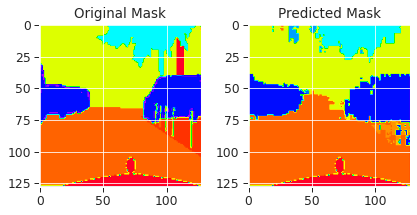

------------------------------------------------------------------------------------------------------------------------
| epoch  19 |   100/  185 batches | train accuracy    0.783 | train loss: 0.62120  | train mIOU: 0.278
------------------------------------------------------------------------------------------------------------------------
| end of epoch  19 | time: 40.92s | valid accuracy:    0.729 | valid loss: 0.79391 | valid mIOU: 0.228


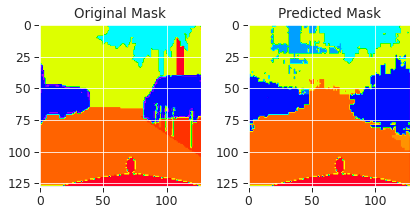

------------------------------------------------------------------------------------------------------------------------
| epoch  20 |   100/  185 batches | train accuracy    0.738 | train loss: 0.72836  | train mIOU: 0.260
------------------------------------------------------------------------------------------------------------------------
| end of epoch  20 | time: 39.95s | valid accuracy:    0.738 | valid loss: 0.59454 | valid mIOU: 0.269


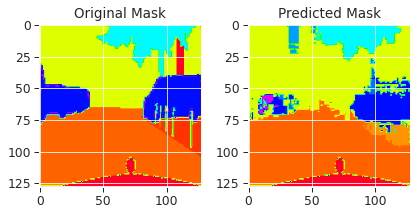

------------------------------------------------------------------------------------------------------------------------
| epoch  21 |   100/  185 batches | train accuracy    0.768 | train loss: 0.55582  | train mIOU: 0.287
------------------------------------------------------------------------------------------------------------------------
| end of epoch  21 | time: 40.61s | valid accuracy:    0.739 | valid loss: 0.57335 | valid mIOU: 0.256


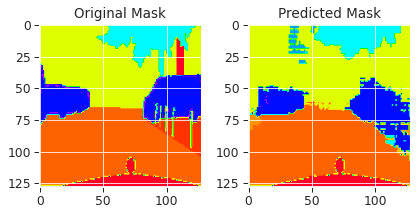

------------------------------------------------------------------------------------------------------------------------
| epoch  22 |   100/  185 batches | train accuracy    0.790 | train loss: 0.51068  | train mIOU: 0.286
------------------------------------------------------------------------------------------------------------------------
| end of epoch  22 | time: 41.01s | valid accuracy:    0.756 | valid loss: 0.57118 | valid mIOU: 0.265


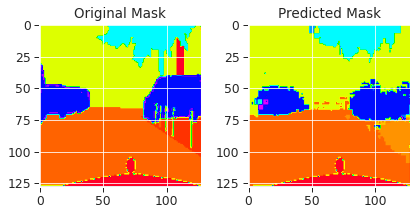

------------------------------------------------------------------------------------------------------------------------
| epoch  23 |   100/  185 batches | train accuracy    0.802 | train loss: 0.42567  | train mIOU: 0.279
------------------------------------------------------------------------------------------------------------------------
| end of epoch  23 | time: 40.69s | valid accuracy:    0.757 | valid loss: 0.55918 | valid mIOU: 0.269


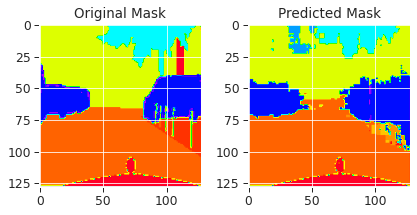

------------------------------------------------------------------------------------------------------------------------
| epoch  24 |   100/  185 batches | train accuracy    0.801 | train loss: 0.47776  | train mIOU: 0.294
------------------------------------------------------------------------------------------------------------------------
| end of epoch  24 | time: 40.10s | valid accuracy:    0.763 | valid loss: 0.53836 | valid mIOU: 0.268


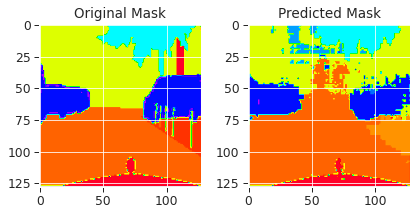

------------------------------------------------------------------------------------------------------------------------
| epoch  25 |   100/  185 batches | train accuracy    0.801 | train loss: 0.43761  | train mIOU: 0.325
------------------------------------------------------------------------------------------------------------------------
| end of epoch  25 | time: 40.18s | valid accuracy:    0.736 | valid loss: 0.56220 | valid mIOU: 0.279


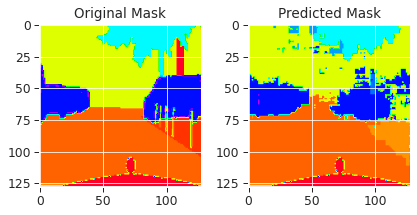

------------------------------------------------------------------------------------------------------------------------
| epoch  26 |   100/  185 batches | train accuracy    0.788 | train loss: 0.49364  | train mIOU: 0.324
------------------------------------------------------------------------------------------------------------------------
| end of epoch  26 | time: 40.68s | valid accuracy:    0.746 | valid loss: 0.54523 | valid mIOU: 0.277


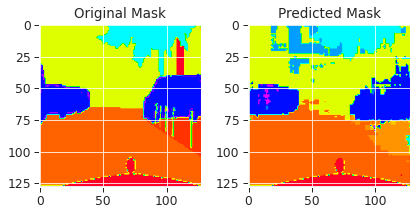

------------------------------------------------------------------------------------------------------------------------
| epoch  27 |   100/  185 batches | train accuracy    0.778 | train loss: 0.58001  | train mIOU: 0.338
------------------------------------------------------------------------------------------------------------------------
| end of epoch  27 | time: 41.82s | valid accuracy:    0.735 | valid loss: 0.56498 | valid mIOU: 0.297


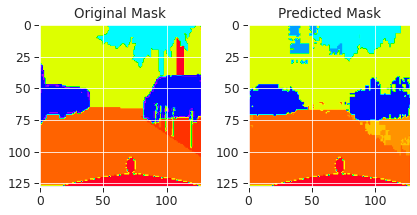

------------------------------------------------------------------------------------------------------------------------
| epoch  28 |   100/  185 batches | train accuracy    0.819 | train loss: 0.38202  | train mIOU: 0.356
------------------------------------------------------------------------------------------------------------------------
| end of epoch  28 | time: 39.93s | valid accuracy:    0.757 | valid loss: 0.51852 | valid mIOU: 0.291


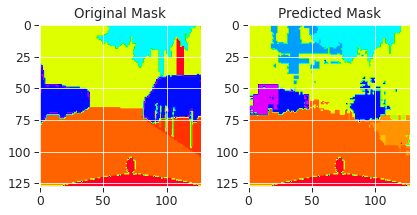

------------------------------------------------------------------------------------------------------------------------
| epoch  29 |   100/  185 batches | train accuracy    0.830 | train loss: 0.34214  | train mIOU: 0.359
------------------------------------------------------------------------------------------------------------------------
| end of epoch  29 | time: 39.86s | valid accuracy:    0.761 | valid loss: 0.51143 | valid mIOU: 0.300


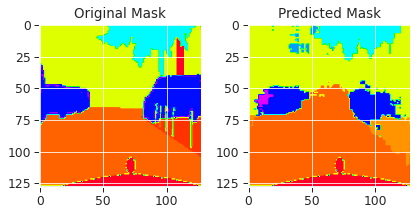

------------------------------------------------------------------------------------------------------------------------
| epoch  30 |   100/  185 batches | train accuracy    0.809 | train loss: 0.57210  | train mIOU: 0.340
------------------------------------------------------------------------------------------------------------------------
| end of epoch  30 | time: 39.82s | valid accuracy:    0.764 | valid loss: 0.49502 | valid mIOU: 0.335


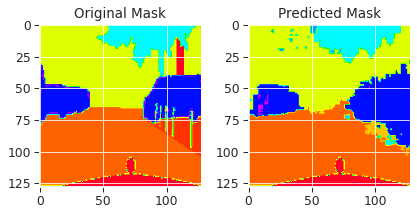

------------------------------------------------------------------------------------------------------------------------
| epoch  31 |   100/  185 batches | train accuracy    0.847 | train loss: 0.37029  | train mIOU: 0.412
------------------------------------------------------------------------------------------------------------------------
| end of epoch  31 | time: 42.08s | valid accuracy:    0.743 | valid loss: 0.53701 | valid mIOU: 0.316


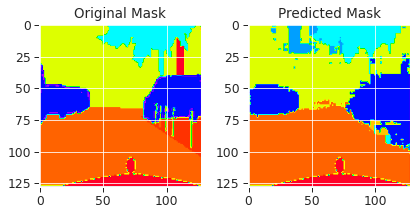

------------------------------------------------------------------------------------------------------------------------
| epoch  32 |   100/  185 batches | train accuracy    0.844 | train loss: 0.38793  | train mIOU: 0.372
------------------------------------------------------------------------------------------------------------------------
| end of epoch  32 | time: 42.04s | valid accuracy:    0.769 | valid loss: 0.51544 | valid mIOU: 0.332


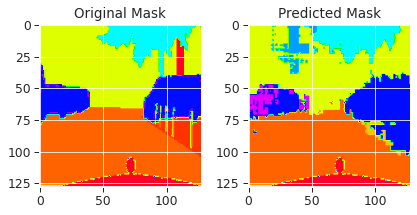

------------------------------------------------------------------------------------------------------------------------
| epoch  33 |   100/  185 batches | train accuracy    0.835 | train loss: 0.42800  | train mIOU: 0.361
------------------------------------------------------------------------------------------------------------------------
| end of epoch  33 | time: 40.18s | valid accuracy:    0.773 | valid loss: 0.48228 | valid mIOU: 0.352


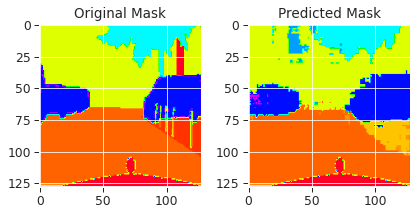

------------------------------------------------------------------------------------------------------------------------
| epoch  34 |   100/  185 batches | train accuracy    0.824 | train loss: 0.48871  | train mIOU: 0.376
------------------------------------------------------------------------------------------------------------------------
| end of epoch  34 | time: 39.80s | valid accuracy:    0.761 | valid loss: 0.49383 | valid mIOU: 0.337


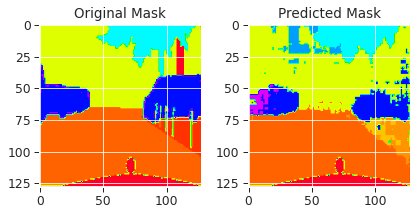

------------------------------------------------------------------------------------------------------------------------
| epoch  35 |   100/  185 batches | train accuracy    0.885 | train loss: 0.35498  | train mIOU: 0.408
------------------------------------------------------------------------------------------------------------------------
| end of epoch  35 | time: 39.83s | valid accuracy:    0.803 | valid loss: 0.49357 | valid mIOU: 0.337


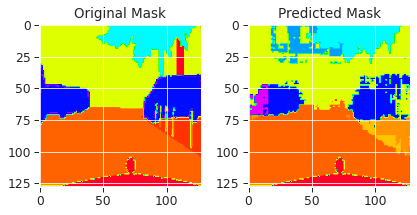

------------------------------------------------------------------------------------------------------------------------
| epoch  36 |   100/  185 batches | train accuracy    0.905 | train loss: 0.29110  | train mIOU: 0.415
------------------------------------------------------------------------------------------------------------------------
| end of epoch  36 | time: 41.24s | valid accuracy:    0.832 | valid loss: 0.40846 | valid mIOU: 0.373


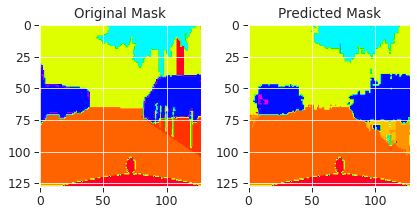

------------------------------------------------------------------------------------------------------------------------
| epoch  37 |   100/  185 batches | train accuracy    0.902 | train loss: 0.26069  | train mIOU: 0.421
------------------------------------------------------------------------------------------------------------------------
| end of epoch  37 | time: 41.60s | valid accuracy:    0.804 | valid loss: 0.47285 | valid mIOU: 0.352


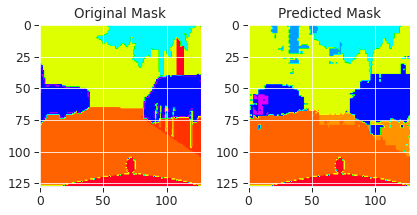

------------------------------------------------------------------------------------------------------------------------
| epoch  38 |   100/  185 batches | train accuracy    0.873 | train loss: 0.39749  | train mIOU: 0.387
------------------------------------------------------------------------------------------------------------------------
| end of epoch  38 | time: 40.38s | valid accuracy:    0.813 | valid loss: 0.47415 | valid mIOU: 0.350


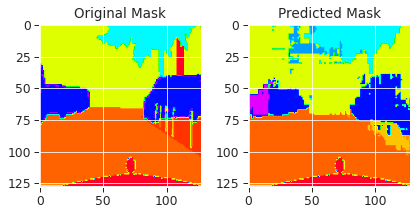

------------------------------------------------------------------------------------------------------------------------
| epoch  39 |   100/  185 batches | train accuracy    0.903 | train loss: 0.29257  | train mIOU: 0.414
------------------------------------------------------------------------------------------------------------------------
| end of epoch  39 | time: 40.44s | valid accuracy:    0.825 | valid loss: 0.42973 | valid mIOU: 0.361


------------------------------------------------------------------------------------------------------------------------
| epoch  40 |   100/  185 batches | train accuracy    0.877 | train loss: 0.38649  | train mIOU: 0.416
------------------------------------------------------------------------------------------------------------------------
| end of epoch  40 | time: 39.82s | valid accuracy:    0.834 | valid loss: 0.41718 | valid mIOU: 0.370


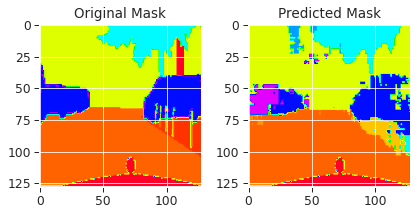

------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Model Training

batch_size = 16
train_loader = make_dataloader(X_train.numpy(), Y_train.numpy(), batch_size, True)
val_loader = make_dataloader(X_valid.numpy(), Y_valid.numpy(), batch_size, False)

# Hyperparameters
epochs =42  # epoch
lr = 0.001
gradient_norm_clips = 0.1
gradient_norm_clip = 1

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-8)

total_accu = None
for epoch in range(1, epochs + 1):
    
    epoch_start_time = time.time()
    train(model, train_loader, loss_func, device, gradient_norm_clip)
    # accu_val, accu_loss, iou = evaluate(model, val_loader, loss_func, device)
    accu_val, accu_loss, mean_IOU= evaluate(model, val_loader, loss_func, device)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 120)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy: {:8.3f} | valid loss: {:.5f} | valid mIOU: {:.3f}'.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val, accu_loss, mean_IOU))
    viz_callback = VizCallback("cityscapes_data/val/295.jpg")
    viz_callback.on_epoch_end(model)
    print('-' * 120)

# Saving Model

In [17]:
torch.save(model.state_dict(), "swin_transformer_b16_128")

# Evaluating Model on test data

In [1]:
test_loader = make_dataloader(X_test.numpy(), Y_test.numpy(), batch_size=16,is_train=False)
accu_val, accu_loss, mean_IOU = evaluate(model, val_loader, loss_func, device)
print('Test accuracy: {:8.3f} | Test loss: {:.5f} | Test mIOU: {:.3f}'.format(accu_val, accu_loss, mean_IOU))


Test accuracy:    0.821 | Test loss: 0.43945 | Test mIOU: 0.363
